## Introduction

Thanks to my old man not wanting to teach me his native language when I was a young child, my Japanese sucks. Reading is especially difficult and when reading handwritten characters, especially calligraphy, I'm practically illiterate.

In this notebook, I will use the KMNIST dataset to see if we can differentiate between various hiragana characters in calligraphy.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

!pip install tensorflow-datasets
import tensorflow as tf
import tensorflow_datasets as tfds

!pip install keras_tuner
import keras
import keras_tuner
from keras import layers, regularizers
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, TensorBoard

import json
from sklearn.metrics import confusion_matrix

## The data

The data is from one of TensorFlow's built-in datasets: KMNIST.
Translated homepage [here](http://codh.rois.ac.jp/kmnist/index.html.en).

It is a replacement for the MNIST dataset (28x28 grayscale, 70,000 images), but due to the restriction of 10 classes (or labels), we have the following characters representing each of the 10 rows of Hiragana: お, き, す, つ, な, は, ま, や, れ, and を.

## Load the data

In [2]:
(train_ds, test_ds), info = tfds.load(
    'kmnist',
    split=['train', 'test'],
    with_info=True, # Download data with info
    as_supervised=True, # Include labels
)

## Explore the contents of the data sets

Let's see the dimensions of the data we're working with.

In [3]:
image_size = info.features['image'].shape
num_classes = info.features['label'].num_classes
data_size = info.splits['train'].num_examples

print(image_size) # size of each image.
print(num_classes) # ten classes/labels.
print(data_size) # Total number of images.

(28, 28, 1)
10
60000


Let's now get an example image for each of the ten labels.

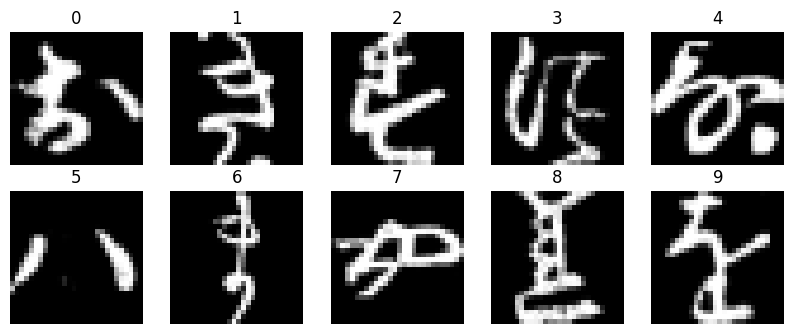

In [4]:
# Image plotter function
def plot_label_images(images, labels, num_labels):
    plt.figure(figsize=(10, 10))
    for i in range(num_labels):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(str(labels[i]))
        plt.axis('off')
    plt.show()

# Image Dictionary: one image per label
label_images = {}
num_labels = 10

# Extract one image for each label
for image, label in train_ds:
    label = label.numpy()
    if label not in label_images:
        label_images[label] = image.numpy()
    if len(label_images) == num_labels:
        break

# Prepare images and labels for plotting
images = [label_images[label] for label in sorted(label_images.keys())]
labels = sorted(label_images.keys())

# Plot the images
plot_label_images(images, labels, num_labels)

# Recall [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] = [お, き, す, つ, な, は, ま, や, れ, を].

From the examples above and knowing the characters, I would make the guess that さ(2) and を(9) will have inaccuracies as well as き(1) and ま(6).

## Preprocessing

Now we have to get our images into a normalized 1D array before we can throw it into a Neural Network.

In [5]:
# Flattens images to 1D array
def flatten_image(image):
    return np.ravel(image)

# Normalizes flattened images
def normalize_image(image):
    return image / 255.0

# Performs both functions above on all images in our dataset
def preprocess_dataset(dataset):
    flattened_normalized_images = []
    labels = []
    for image, label in dataset:
        flattened_image = flatten_image(image.numpy())
        normalized_image = normalize_image(flattened_image)
        flattened_normalized_images.append(normalized_image)
        labels.append(label.numpy())
    return np.array(flattened_normalized_images), np.array(labels)

Let's split our newly flattend and normalized dataset into a train and test set then verify that we have the right dimensions for our images and their labels.

In [6]:
X_train, y_train = preprocess_dataset(train_ds)
X_test, y_test = preprocess_dataset(test_ds)

print(f"Flattened and normalized train images shape: {X_train.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Flattened and normalized test images shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Flattened and normalized train images shape: (60000, 784)
Train labels shape: (60000,)
Flattened and normalized test images shape: (10000, 784)
Test labels shape: (10000,)


## Custom Neural Networks

Now that our images are in the right format, we can pass them through a CNN!

But first, we have to build a model that balances speed and accuracy.

### Building the CNN:

We can build a very accurate model but it will cost some amount of speed. In the sections below, the codes with adjustable values will have ###comments indicating where we change the values, giving us a different speed/accuracy balance.

In [7]:
def define_model(units, num_layers, activation, lr, l2):
    model_layers = [
        layers.Dense(units, activation=activation, kernel_regularizer=regularizers.L2(l2=l2), kernel_initializer=keras.initializers.HeNormal())
        ] * num_layers  # These are the main hidden layers
    model_layers += [layers.Dense(10)]  # This is the output layer, which should have the same size as the number of classes you are trying to predict
    model = keras.Sequential(model_layers)  # This just stacks all our layers on top of each other
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'],
                  optimizer=Adam(learning_rate=lr))  # This is a good loss/penalty function to use for multi-class classification

    return model

In [8]:
def build_model(hp):
    units = hp.Choice("units", [256, 512])
    activation = "relu"   # We'll just use ReLu for now

    lr = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")  ### Adjustable min and max values
    l2 = hp.Float("l2", min_value=1e-5, max_value=1e-1, sampling="log")  ### Adjustable L2 regularization range

    num_layers = hp.Choice("num_layers", [2, 3, 4, 5, 6])  ### Play around with the number of layers

    # call existing model-building code with the hyperparameter values.
    model = define_model(units=units, num_layers=num_layers, activation=activation, lr=lr, l2=l2)
    return model

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss", # We want to see accuracy improve on the validation (or test) dataset
    max_trials=12,  ### How many parameter combinations you want to try (lower is faster but less accurate)
    executions_per_trial=1,
    overwrite=False,
    directory="/content/drive/MyDrive/models/kmnist_sweep_3", # Save the output somewhere you've created. CHANGE NUMBER FOR EACH RUNTHROUGH.
)

Reloading Tuner from /content/drive/MyDrive/models/kmnist_sweep_3/untitled_project/tuner0.json


In [11]:
# This is a "callback" function, which will get called at the end of every epoch to check whether the accuracy is still increasing.
callbacks = [EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, start_from_epoch=5)] ### patience and start_from_epoch are adjustable.

In [12]:
tuner.search(
    X_train,
    y_train,
    epochs=12, ###(lower is faster but less accurate)
    verbose=1, #1 to view status, 0 to hide.
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Now that we passed the images through the Neural Network multiple times, let's check which trial gave us the best results and look at the confusion matrix that shows the accuracy of our model.

In [13]:
# Examining the top 3 results
tuner.results_summary(3)

Results summary
Results in /content/drive/MyDrive/models/kmnist_sweep_3/untitled_project
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 08 summary
Hyperparameters:
units: 512
lr: 0.0006430777171446815
l2: 2.7025729174738344e-05
num_layers: 3
Score: 0.37801069021224976

Trial 09 summary
Hyperparameters:
units: 512
lr: 0.0002339907073111066
l2: 0.0002540679935199547
num_layers: 5
Score: 0.3838600814342499

Trial 04 summary
Hyperparameters:
units: 256
lr: 5.186297414751111e-05
l2: 8.228404304578192e-05
num_layers: 5
Score: 0.5322481989860535


After playing around with the numbers, the best model was trial number 08 from the KMNIST sweep 3 file. Let's load it in to make a prediction.

In [14]:
trial_num = "08"
with open(f"/content/drive/MyDrive/models/kmnist_sweep_3/untitled_project/trial_{trial_num}/trial.json", "r") as f: # VERIFY SWEEP NUMBER
    trial = json.load(f)
hp = trial["hyperparameters"]["values"]
model = define_model(units=hp["units"], num_layers=hp["num_layers"], activation="relu", lr=hp["lr"],
                     l2=hp["l2"])
model.load_weights(f"/content/drive/MyDrive/models/kmnist_sweep_3/untitled_project/trial_{trial_num}/checkpoint") # VERIFY SWEEP NUMBER

Confusion Matrix

In [15]:
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracy = sum(y_pred == y_test) / len(y_test)
print(accuracy)
print(cm)

313/313 [==============================] - 3s 4ms/step
0.9052
[[912   4   1   4  23  18   8  19  10   1]
 [  1 895   9   3  11   6  42   2  10  21]
 [ 10  11 850  58   8  15  13   6  17  12]
 [  2   4  17 960   1   6   3   3   3   1]
 [ 22  24   3  11 887  11  20   4  13   5]
 [  6  11  31  11   6 921  10   0   2   2]
 [  3   6  17  13   8   6 944   0   2   1]
 [ 15  18  12   4   9   6  24 872  20  20]
 [  7  23   5  36   2   6   7   1 909   4]
 [  9   8  20   5  25   1  15   1  14 902]]


Here, we can see that the model is pretty accurate. We went from being able to randomly guess correctly 10% of the time to now predicting over 90% correctly.

We can see nice chunky values along the diagonals, showing the correct predictions, but there are still some existing inaccuracies (code below will again show the ten labels for reference). The two highest being す(2) mistaken for つ(3) and き(1) mistaken for ま(6), one of my initial guesses. My other guess of さ(2) and を(9) seems above average when it comes to the number of wrong predictions, but certainly not the highest.

For き(1) and ま(6), we can see the similarities in modern text as well as in the examples below, but す(2) and つ(3) look almost nothing alike in both cases.

Another thing of interest is the difference between the top six inaccurate entries and their transposed counterparts: i.e. the pair す(2), つ(3) and the pair つ(3), す(2). In all six cases, the counterparts were no more than half of their respective top-value entries.

If Colab provided higher computing power for the same free price, I would have liked to try to increase the number of layers to see if these top innacuracies would change and if so, by how much.

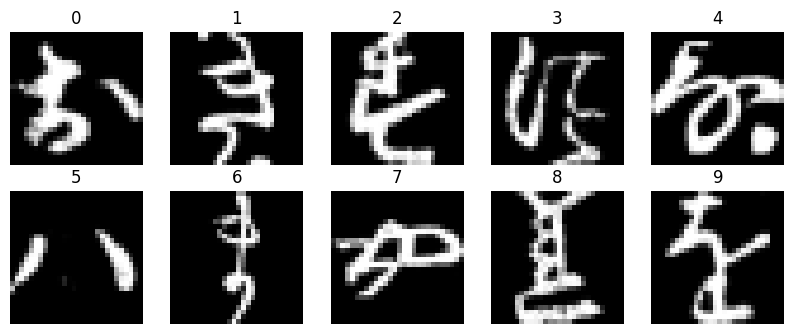

In [16]:
plot_label_images(images, labels, num_labels)

## Conclusion

This notebook presents an approach to image classification using a CNN. We first demonstrated the process of image preprocessing of flattening and normalization. Then, after running the images through multiple CNNs with different combinations of lr and l2 min/max values as well as differing numbers of layers, trials, and epochs, we arrived at a model with 90.52% predictive accuracy and visualized it using a confusion matrix.

While reading calligraphy will still be incredibly difficult for me, perhaps having the ability to know, with 90% accuracy, which consonant group a character belongs to will help with reading via context or process of elimination.
